<a href="https://colab.research.google.com/github/urbanik/DP/blob/main/raindrop%26insect_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next look at:

Why use validation 

Regularization(parameter)

Dropout

BatchNormalization


Imports

In [6]:
import torch, torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torchsummary import summary

import numpy as np
from skimage import io
import pandas as pd
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time

**Device**

What is cuda - https://www.infoworld.com/article/3299703/what-is-cuda-parallel-programming-for-gpus.html

Cuda is parallel computing platform and programming model 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Dataset**
Data transformation - different sizes of input pictures of adherent raindrops and insect

Creating batches of different sizes 
https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278

Custom dataset 
https://www.youtube.com/watch?v=ZoZHd0Zm3RY
Custam dataset on Google Colab
https://www.youtube.com/watch?v=b4R9WvfHs4M


Resizing
https://discuss.pytorch.org/t/does-resize-affect-image-details/86503




In [8]:
#ARAI - Adherent Raindrops And Insect
class ARAI_dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      img_PIL = transforms.ToPILImage()(image)
      img_PIL = transforms.Resize([100, 100])(img_PIL)
      img = self.transform(img_PIL)
      
    
    return img, y_label

In [9]:
dataset = ARAI_dataset(csv_file='/content/drive/MyDrive/Colab Notebooks/DATA/ARAI_labels.csv', root_dir='/content/drive/MyDrive/Colab Notebooks/DATA/ARAI/images', transform=transforms.ToTensor())
len(dataset)
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [950, 200, 10])

train_data_size = len(train_set)
valid_data_size = len(valid_set)

# Get a mapping of the indices to the class names, in order to see the output classes of the test images. -NOT WOKING YET
#idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}
#print(idx_to_class)

# loaders
batch_size = 32
train_data_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

tensor(1)


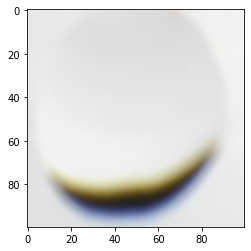

In [10]:
example = test_set[2]
print(example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

ALEXNET
https://www.youtube.com/watch?v=8etkVC93yU4

In [11]:
AlexNet = models.alexnet(pretrained=True)
AlexNet#freezing parameters
for param in AlexNet.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


TRANSFER LEARNING

The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction.

https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Example of implementation -
https://www.youtube.com/watch?v=8etkVC93yU4

Github - https://github.com/madsendennis/notebooks/blob/master/pytorch/3_PyTorch_Transfer_learning.ipynb 

Similar work - https://github.com/GTC7788/raindropDetection

https://github.com/tobybreckon/raindrop-detection-cnn

In [12]:
#freezing parameters - TRANSFERLEARNING
for param in AlexNet.parameters():
  param.requires_grad = False


In [13]:
#change of the final layer of AlexNet model 
AlexNet.classifier[6] = nn.Linear(4096, 3) # we have 2 classes already
AlexNet.classifier.add_module("7", nn.LogSoftmax(dim=1))
AlexNet.to(device) # in case we use GPU

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Loss function
NLLLoss - https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html


In [14]:
loss_func = nn.NLLLoss()

Optimizer

In [15]:
optimizer = optim.Adam(AlexNet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Train and validate function

In [16]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
  start = time.time()
  history = []
  best_acc = 0.0
  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_data_loader):

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # clean existing gradients

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)
      
      # Compute loss
      loss = loss_criterion(outputs, labels)
      
      # Backpropagate the gradients
      loss.backward()
      
      # Update the parameters
      optimizer.step()
      
      # Compute the total loss for the batch and add it to train_loss
      train_loss += loss.item() * inputs.size(0)
      
      # Compute the accuracy
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))
      
      # Convert correct_counts to float and then compute the mean
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      
      # Compute total accuracy in the whole batch and add to train_acc
      train_acc += acc.item() * inputs.size(0)
    # Validation - No gradient tracking needed
    with torch.no_grad():

      # Set to evaluation mode
      model.eval()

      # Validation loop
      for j, (inputs, labels) in enumerate(valid_data_loader):
          inputs = inputs.to(device) # cuda or cpu
          labels = labels.to(device)

          # Forward pass - compute outputs on input data using the model
          outputs = model(inputs)

          # Compute loss
          loss = loss_criterion(outputs, labels)

          # Compute the total loss for the batch and add it to valid_loss
          valid_loss += loss.item() * inputs.size(0)

          # Calculate validation accuracy
          ret, predictions = torch.max(outputs.data, 1)
          correct_counts = predictions.eq(labels.data.view_as(predictions))

          # Convert correct_counts to float and then compute the mean
          acc = torch.mean(correct_counts.type(torch.FloatTensor))

          # Compute total accuracy in the whole batch and add to valid_acc
          valid_acc += acc.item() * inputs.size(0)

          #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
      
    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 
    avg_train_acc = train_acc/train_data_size

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size 
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
            
    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    
    # Save if the model has best accuracy till now
    #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
          
  return model, history      

Train and validation into graph


In [17]:
num_epochs = 50
trained_model, history = train_and_validate(AlexNet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/50
Epoch : 001, Training: Loss: 0.5290, Accuracy: 75.5789%, 
		Validation : Loss : 0.3621, Accuracy: 84.5000%, Time: 298.7943s
Epoch: 2/50
Epoch : 002, Training: Loss: 0.3868, Accuracy: 82.1053%, 
		Validation : Loss : 0.3185, Accuracy: 85.5000%, Time: 2.9637s
Epoch: 3/50
Epoch : 003, Training: Loss: 0.3091, Accuracy: 87.4737%, 
		Validation : Loss : 0.2969, Accuracy: 89.0000%, Time: 2.9664s
Epoch: 4/50
Epoch : 004, Training: Loss: 0.3103, Accuracy: 86.5263%, 
		Validation : Loss : 0.2936, Accuracy: 89.0000%, Time: 2.9556s
Epoch: 5/50
Epoch : 005, Training: Loss: 0.2930, Accuracy: 88.0000%, 
		Validation : Loss : 0.2894, Accuracy: 88.0000%, Time: 2.9489s
Epoch: 6/50
Epoch : 006, Training: Loss: 0.2727, Accuracy: 88.0000%, 
		Validation : Loss : 0.2657, Accuracy: 89.0000%, Time: 2.9753s
Epoch: 7/50
Epoch : 007, Training: Loss: 0.2690, Accuracy: 88.3158%, 
		Validation : Loss : 0.2922, Accuracy: 89.5000%, Time: 2.9640s
Epoch: 8/50
Epoch : 008, Training: Loss: 0.2511, Accuracy: 9

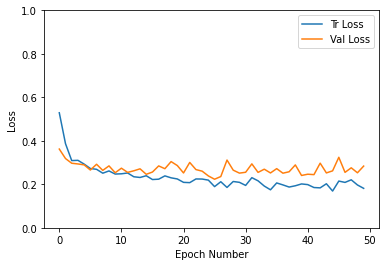

In [18]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

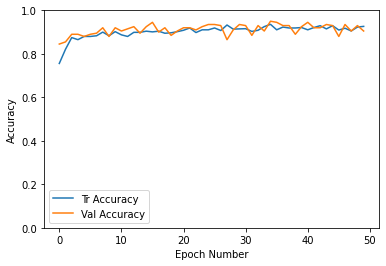

In [19]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

Prediction function


In [20]:
def predict(model, image):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    img_PIL = transforms.ToPILImage()(image)
    img_PIL = transforms.Resize([100, 100])(img_PIL)
    test_image_tensor = transforms.ToTensor()(img_PIL)
    test_image_tensor = test_image_tensor.view(1, 3, 100, 100)
    test_image_tensor = test_image_tensor.to(device)# in case we use GPU

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            topk, topclass = topk.cpu(), topclass.cpu()# in case we use GPU
            print("Predcition", i+1, ":", topclass.numpy()[0][i], ", Score: ", topk.numpy()[0][i]) #idx_to_class[topclass.numpy()[0][i]]

Test on some examples of test data

Predcition 1 : 1 , Score:  0.996226
Predcition 2 : 2 , Score:  0.0037729202
Predcition 3 : 0 , Score:  9.656403e-07
Actual: tensor(1)


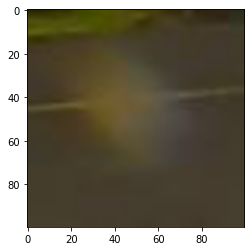

In [21]:
example = test_set[0]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99987245
Predcition 2 : 2 , Score:  0.00012735883
Predcition 3 : 0 , Score:  1.3049515e-07
Actual: tensor(1)


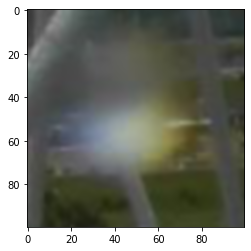

In [22]:
example = test_set[1]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  1.0
Predcition 2 : 2 , Score:  2.8608589e-09
Predcition 3 : 0 , Score:  1.1513428e-10
Actual: tensor(1)


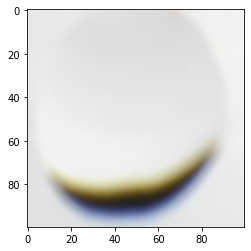

In [23]:
example = test_set[2]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 2 , Score:  0.9451336
Predcition 2 : 1 , Score:  0.05485563
Predcition 3 : 0 , Score:  1.0786308e-05
Actual: tensor(2)


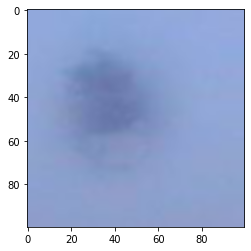

In [24]:
example = test_set[3]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 2 , Score:  0.9907186
Predcition 2 : 1 , Score:  0.009278104
Predcition 3 : 0 , Score:  3.2048033e-06
Actual: tensor(2)


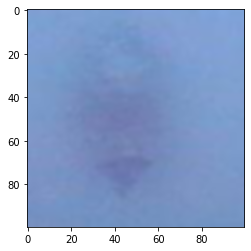

In [25]:
example = test_set[4]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.9999983
Predcition 2 : 2 , Score:  1.7175224e-06
Predcition 3 : 0 , Score:  2.3571372e-09
Actual: tensor(1)


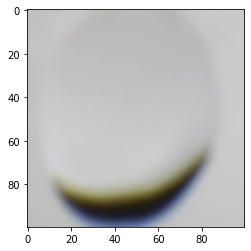

In [26]:
example = test_set[5]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.8302354
Predcition 2 : 2 , Score:  0.16976263
Predcition 3 : 0 , Score:  1.962013e-06
Actual: tensor(2)


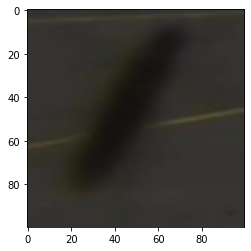

In [27]:
example = test_set[6]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 2 , Score:  0.8642344
Predcition 2 : 1 , Score:  0.13574769
Predcition 3 : 0 , Score:  1.7913133e-05
Actual: tensor(1)


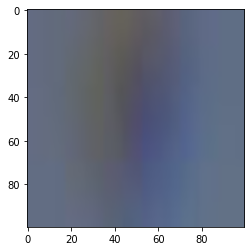

In [28]:
example = test_set[7]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 2 , Score:  0.99999714
Predcition 2 : 1 , Score:  2.8711459e-06
Predcition 3 : 0 , Score:  9.321778e-11
Actual: tensor(2)


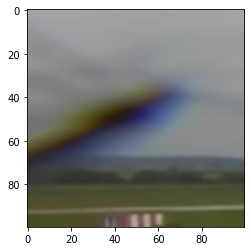

In [29]:
example = test_set[8]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.96656936
Predcition 2 : 2 , Score:  0.033430323
Predcition 3 : 0 , Score:  2.8282923e-07
Actual: tensor(1)


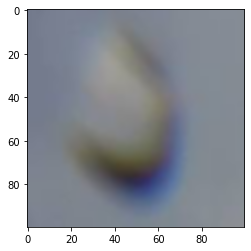

In [30]:
example = test_set[9]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")